In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data/train.csv")

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data.shape

(1460, 81)

## Data Cleaning

In [5]:
# getting percentage of null values in columns having 1 null value
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

1. Looking above, we can remove "Alley","FireplaceQu","PoolQC","Fence" and "MiscFeature" variable as they have very high percentage of null values.
2. We can also remove variables "Id", "MiscVal" as they don't make any sense in model training

In [6]:
# dropping above columns
data.drop(["Alley","FireplaceQu","PoolQC","Fence","MiscFeature","Id","MiscVal"],axis=1,inplace=True)

In [7]:
# shape of resultant dataset
data.shape

(1460, 74)

### Handling null values

In [8]:
data["LotFrontage"].dtype

dtype('float64')

In [9]:
# LotFrontage: Linear feet of street connected to property

In [10]:
data["LotFrontage"].describe(percentiles= [0.25,0.5,0.75,0.8,0.9,0.95])

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
80%        85.000000
90%        96.000000
95%       107.000000
max       313.000000
Name: LotFrontage, dtype: float64

There is a huge difference in 95 percentile and max value. Max value seems an outlier. Hence, we will impute the missing value of LotFrontage with median value.

In [11]:
data["LotFrontage"] = data["LotFrontage"].fillna(value=data["LotFrontage"].median())

There is a huge difference in 95 percentile and max value. Max value seems an outlier. Hence, we will remove all data more than 95 percentile for LotFrontage feature

In [12]:
data = data[data.LotFrontage < data.LotFrontage.quantile(0.95)]

In [13]:
data["LotFrontage"].describe(percentiles= [0.25,0.5,0.75,0.8,0.9,0.95])

count    1385.000000
mean       66.748736
std        15.912072
min        21.000000
25%        60.000000
50%        69.000000
75%        75.000000
80%        80.000000
90%        85.000000
95%        92.000000
max       103.000000
Name: LotFrontage, dtype: float64

In [14]:
data.shape

(1385, 74)

In [15]:
# no null value in LotFrontage and removed the outliers as well.
data.LotFrontage.isnull().sum()

0

In [16]:
# checking type for below columns having null values
data[["GarageType","GarageYrBlt","GarageFinish","GarageQual","GarageCond"]].dtypes

GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
dtype: object

In [17]:
# checking unique values and counts for all features.
features_list= ["GarageType","GarageYrBlt","GarageFinish","GarageQual","GarageCond"]
for feature in features_list:
    val_counts = data[feature].value_counts()
    print(feature + ": ")
    print(val_counts)

GarageType: 
Attchd     816
Detchd     383
BuiltIn     79
Basment     16
CarPort      7
2Types       6
Name: GarageType, dtype: int64
GarageYrBlt: 
2005.0    62
2004.0    49
2003.0    48
2006.0    47
2007.0    43
          ..
1906.0     1
1927.0     1
1908.0     1
1900.0     1
1933.0     1
Name: GarageYrBlt, Length: 97, dtype: int64
GarageFinish: 
Unf    592
RFn    395
Fin    320
Name: GarageFinish, dtype: int64
GarageQual: 
TA    1241
Fa      47
Gd      13
Ex       3
Po       3
Name: GarageQual, dtype: int64
GarageCond: 
TA    1255
Fa      34
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


Replacing the NA values with "NoGarage" as per definition of features

In [18]:
# according to data description NA can be replaced by NoGarage 
data['GarageType'] = data['GarageType'].replace(np.NaN, 'NoGarage')
data['GarageYrBlt'] = data['GarageYrBlt'].replace(np.NaN, 0.0)
data['GarageFinish'] = data['GarageFinish'].replace(np.NaN, 'NoGarage')
data['GarageCond'] = data['GarageCond'].replace(np.NaN, 'NoGarage')
data['GarageQual'] = data['GarageQual'].replace(np.NaN, 'NoGarage')

Replacing the NA values of basement features with "NoBasement" as per definition of features

In [19]:
# according to data description NA can be replaced by NoBasement
data['BsmtCond'] = data['BsmtCond'].replace(np.NaN,'NoBasement')
data['BsmtQual'] = data['BsmtQual'].replace(np.NaN,'NoBasement')
data['BsmtFinType2'] = data['BsmtFinType2'].replace(np.NaN,'NoBasement')
data['BsmtExposure'] = data['BsmtExposure'].replace(np.NaN,'NoBasement')
data['BsmtFinType1'] = data['BsmtFinType1'].replace(np.NaN,'NoBasement')

In [20]:
# Checking again for null values
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

MasVnrType    0.505415
MasVnrArea    0.505415
Electrical    0.072202
dtype: float64

In [21]:
# data type for column "MasVnrArea"
data["MasVnrArea"].dtype

dtype('float64')

In [22]:
# printing number of null values for remaining columns having null values
print("Null values total for MasVnrType feature is: " + str(data['MasVnrType'].isnull().sum()))
print("Null values total for MasVnrArea feature is: " + str(data['MasVnrArea'].isnull().sum()))
print("Null values total for Elactrical feature is: " + str(data['Electrical'].isnull().sum()))

Null values total for MasVnrType feature is: 7
Null values total for MasVnrArea feature is: 7
Null values total for Elactrical feature is: 1


1. We can replace 'MasVnrType' value as None according to feature definition.
2. We can replace 'MasVnrArea' value as 0.0 as it is float value.
3. We can remove the null row of feature 'Electrical' as it equals 1 only.

In [23]:
data['MasVnrType'] = data['MasVnrType'].replace(np.NaN, 'None')
data['MasVnrArea'] = data['MasVnrArea'].replace(np.NaN, 0.0)

In [24]:
# removing null row for Electrical feature
data = data[~(data['Electrical'].isnull())]

In [25]:
# Checking again for null values
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

Series([], dtype: float64)

No Null value in dataset present.

In [26]:
data.shape

(1384, 74)

### Creating columns

creating a new column named "Yr_diff" which will be difference between YrSold and YearBuilt. This columns gives details of after how many years the house was sold.

In [27]:
data["Yr_diff"] = data["YrSold"] - data["YearBuilt"]

In [28]:
data["Yr_diff"].describe()

count    1384.000000
mean       37.131503
std        30.161317
min         0.000000
25%         8.000000
50%        36.000000
75%        55.000000
max       136.000000
Name: Yr_diff, dtype: float64

creating a new column "remodeled" which will be binary categorical feature conatining values Yes/No. Yes means that the feature has been remodeled and no means not remodelled.

In [29]:
# definiting conditions
data["remodeled"] = np.where(data["YearRemodAdd"] == data["YearBuilt"], "No", "Yes")

## Data Visualization

In [30]:
# getting all numerical column present in dataset
numericCols = data.select_dtypes(include=['float64','int64'])
numericCols.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold',
       'YrSold', 'SalePrice', 'Yr_diff'],
      dtype='object')

creating pairplot for numerical columns

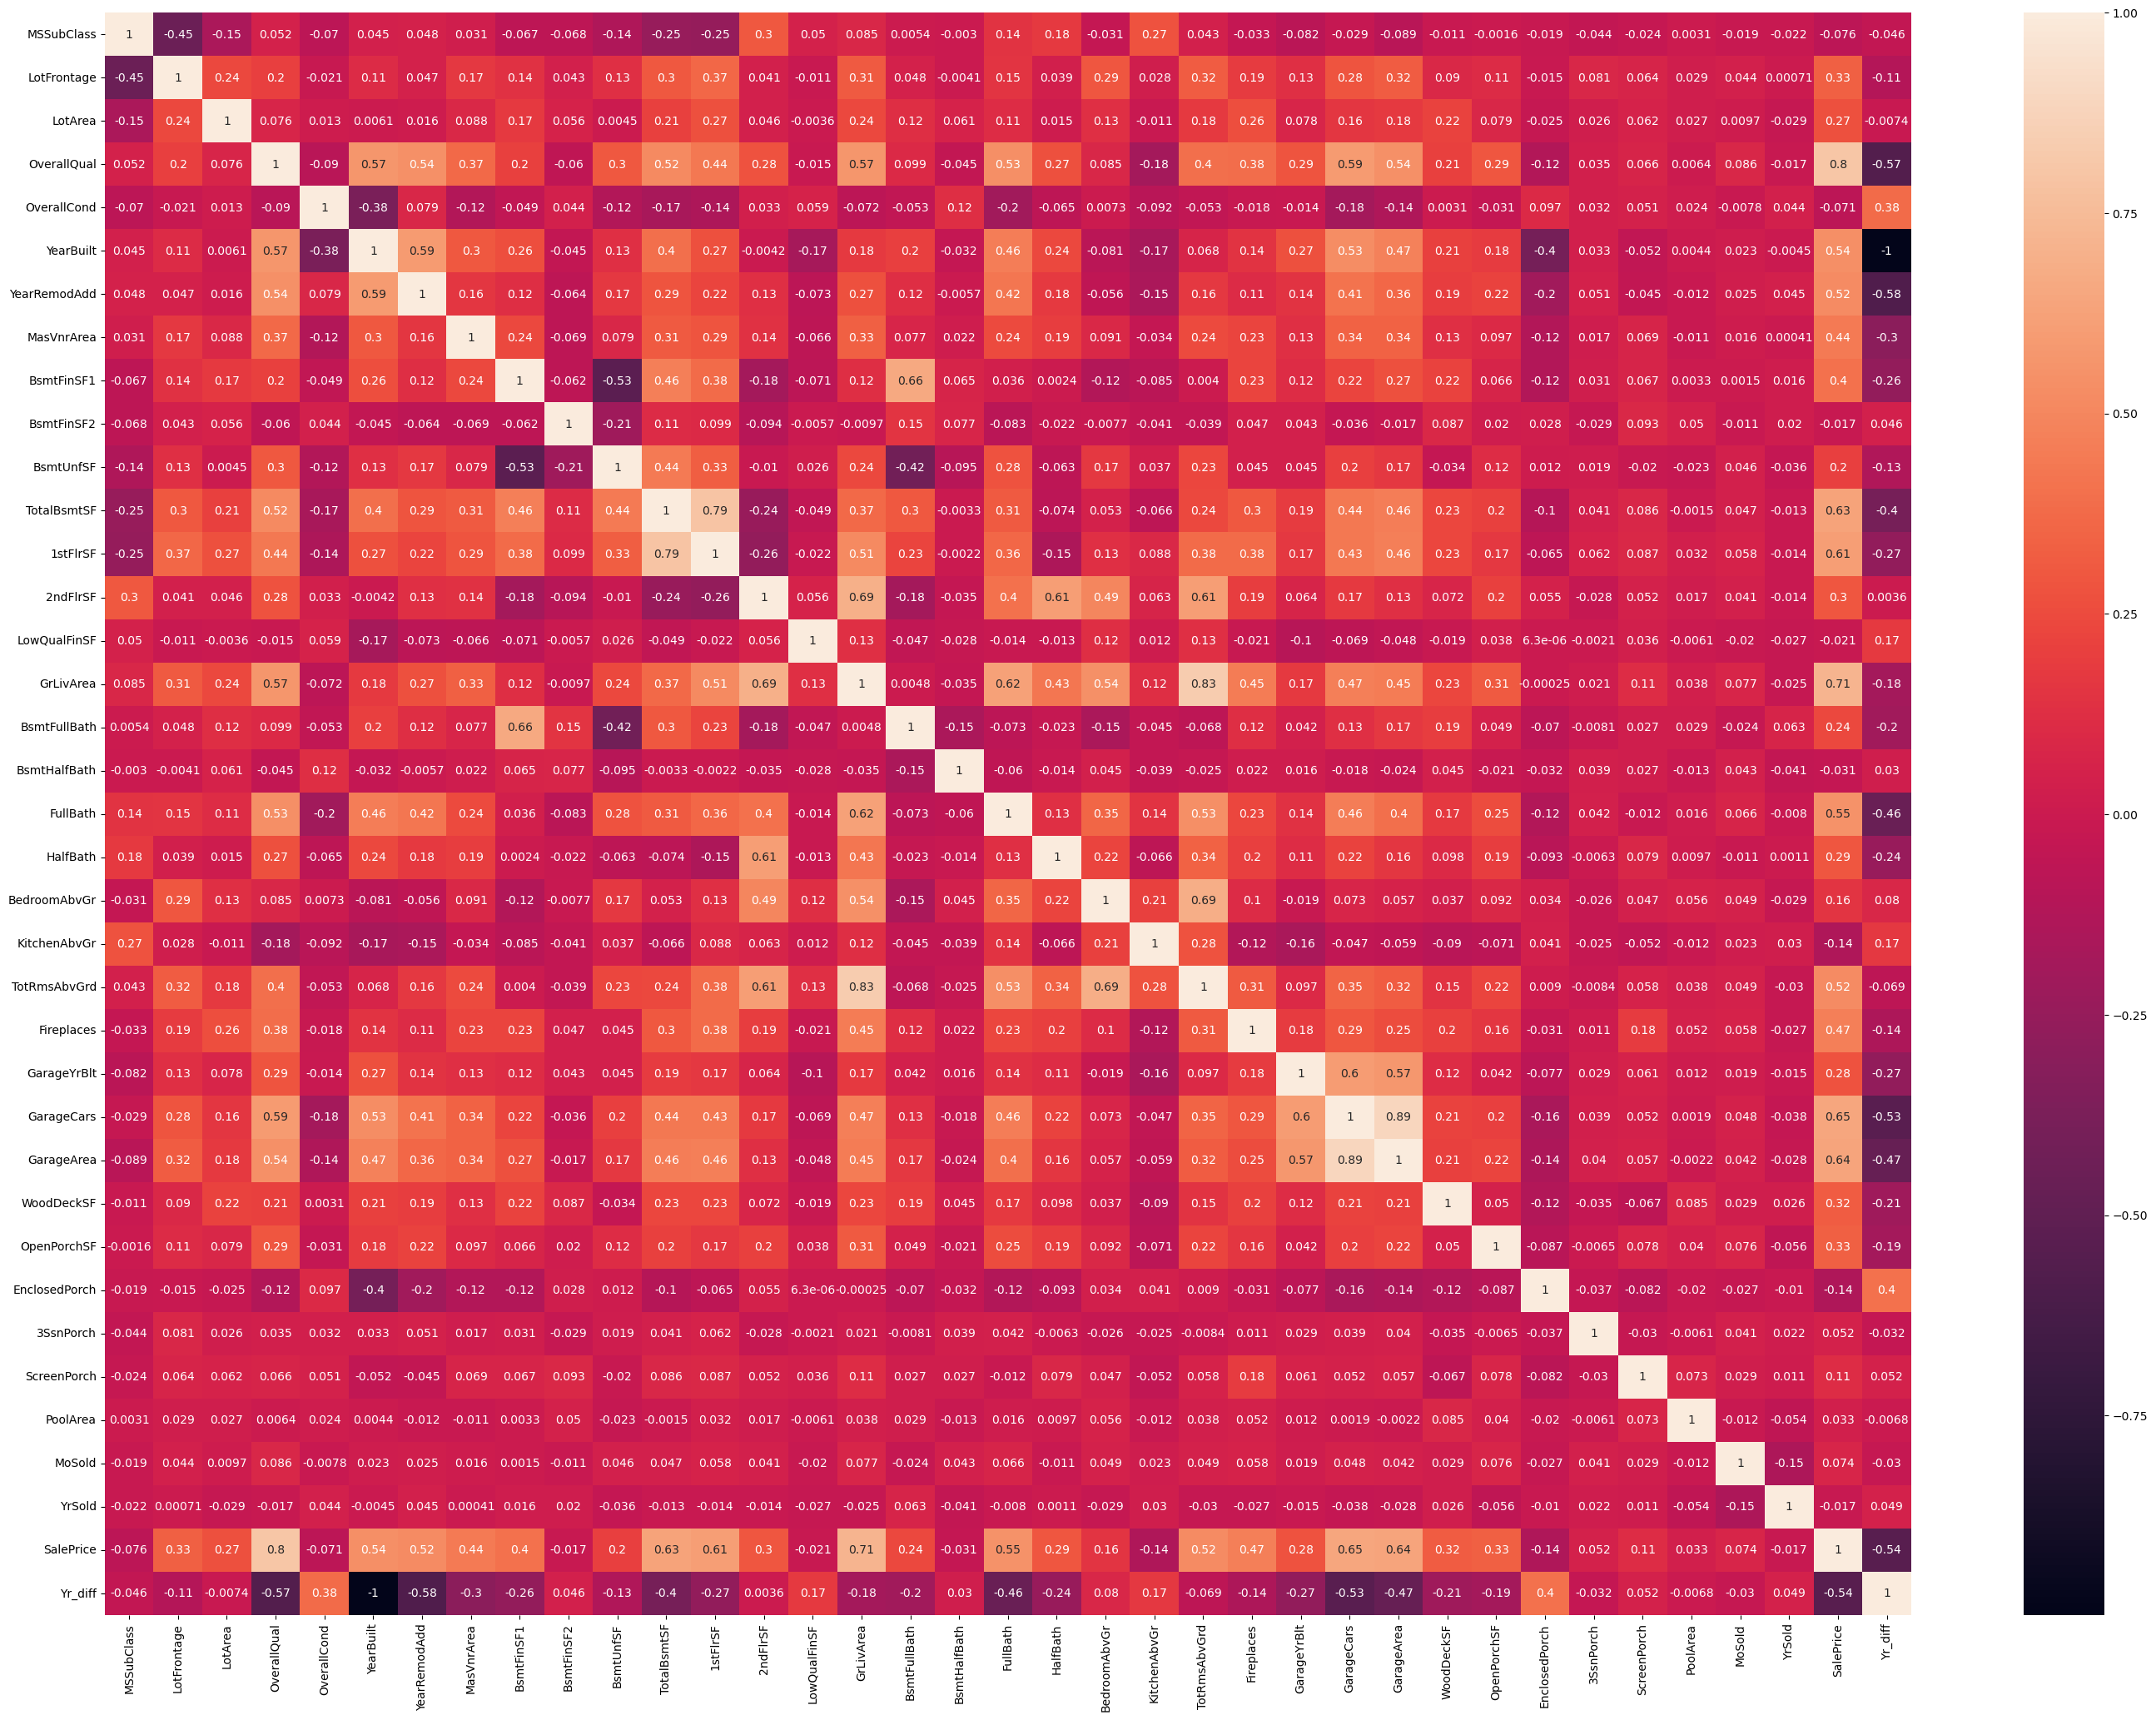

In [31]:
## finding out correlation between independant variables and correlation wrt to target variable SalePrice
plt.figure(figsize = (35, 25))
sns.heatmap(data[numericCols.columns].corr(),annot = True)
plt.show()

1. OverallQual , TotalBsmtSF, 1stFlrSF, GriLivArea , GarageCars, GarageArea and FullBath have high correlation with SalePrice
2. GarageCars and GarageArea have high correlation of 0.89
3. GrLivArea and TotRmsAbvGrd have high correlation of 0.83
4. YearBuilt and Yr_diff have correlation of 1.

As correlation between independant variables are high hence we can remove one of them. Removing GarageCars,TotRmsAbvGrd and YearBuilt variables from dataset.

In [32]:
# removing GarageCars,TotRmsAbvGrd from data.
data.drop(["GarageCars","TotRmsAbvGrd","YearBuilt"],axis=1,inplace=True)

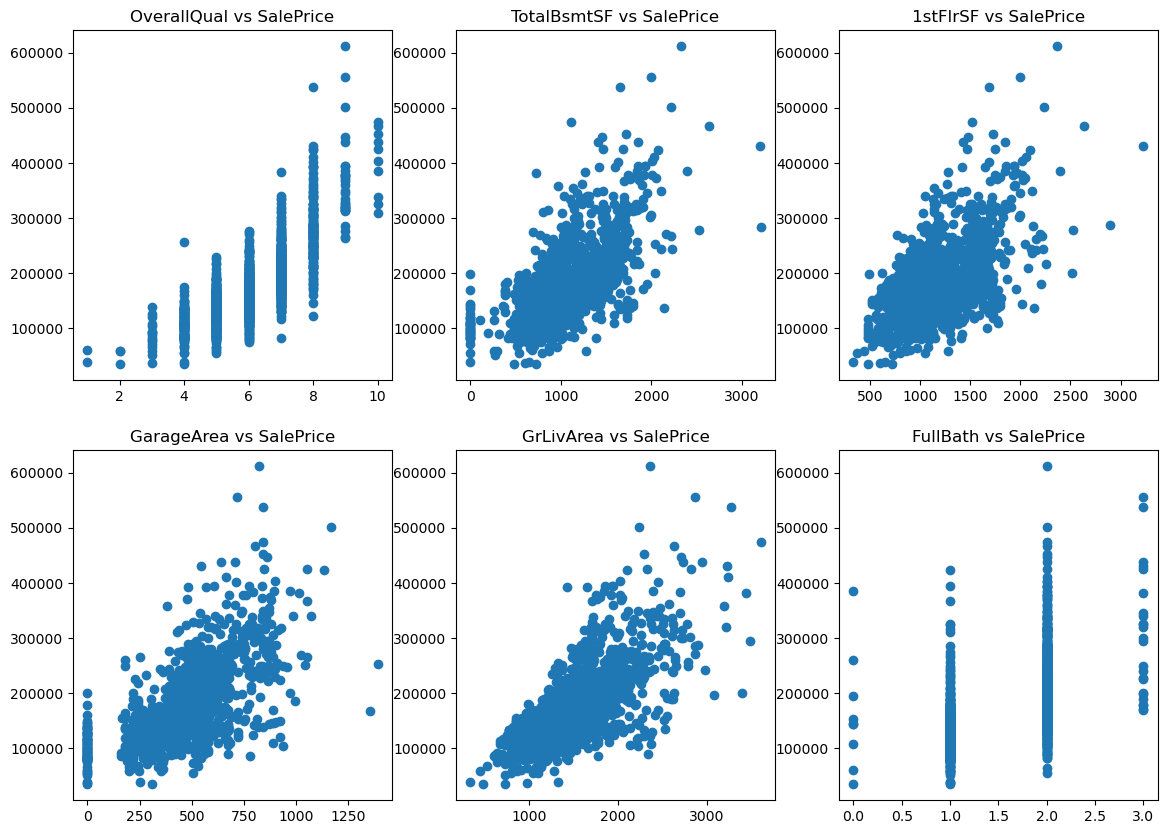

In [33]:
# Creating plots for above numeric Columns with SalePrice

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.scatter(data['OverallQual'],data.SalePrice)
ax1.title.set_text("OverallQual vs SalePrice")

ax2.scatter(data['TotalBsmtSF'],data.SalePrice)
ax2.title.set_text("TotalBsmtSF vs SalePrice")

ax3.scatter(data['1stFlrSF'],data.SalePrice)
ax3.title.set_text("1stFlrSF vs SalePrice")

ax4.scatter(data['GarageArea'],data.SalePrice)
ax4.title.set_text("GarageArea vs SalePrice")

ax5.scatter(data['GrLivArea'],data.SalePrice)
ax5.title.set_text("GrLivArea vs SalePrice")

ax6.scatter(data['FullBath'],data.SalePrice)
ax6.title.set_text("FullBath vs SalePrice")

plt.show()

Can see that Independant variables have linear relationship with target variable SalePrice.

In [34]:
data.shape

(1384, 73)

Analyzing categorical variables now

In [35]:
#identifying categorical variables
categorical = data.select_dtypes(include=['object'])

In [36]:
categorical.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition', 'remodeled'],
      dtype='object')

Getting histograms for all categorical variables

<AxesSubplot: xlabel='Condition1', ylabel='count'>

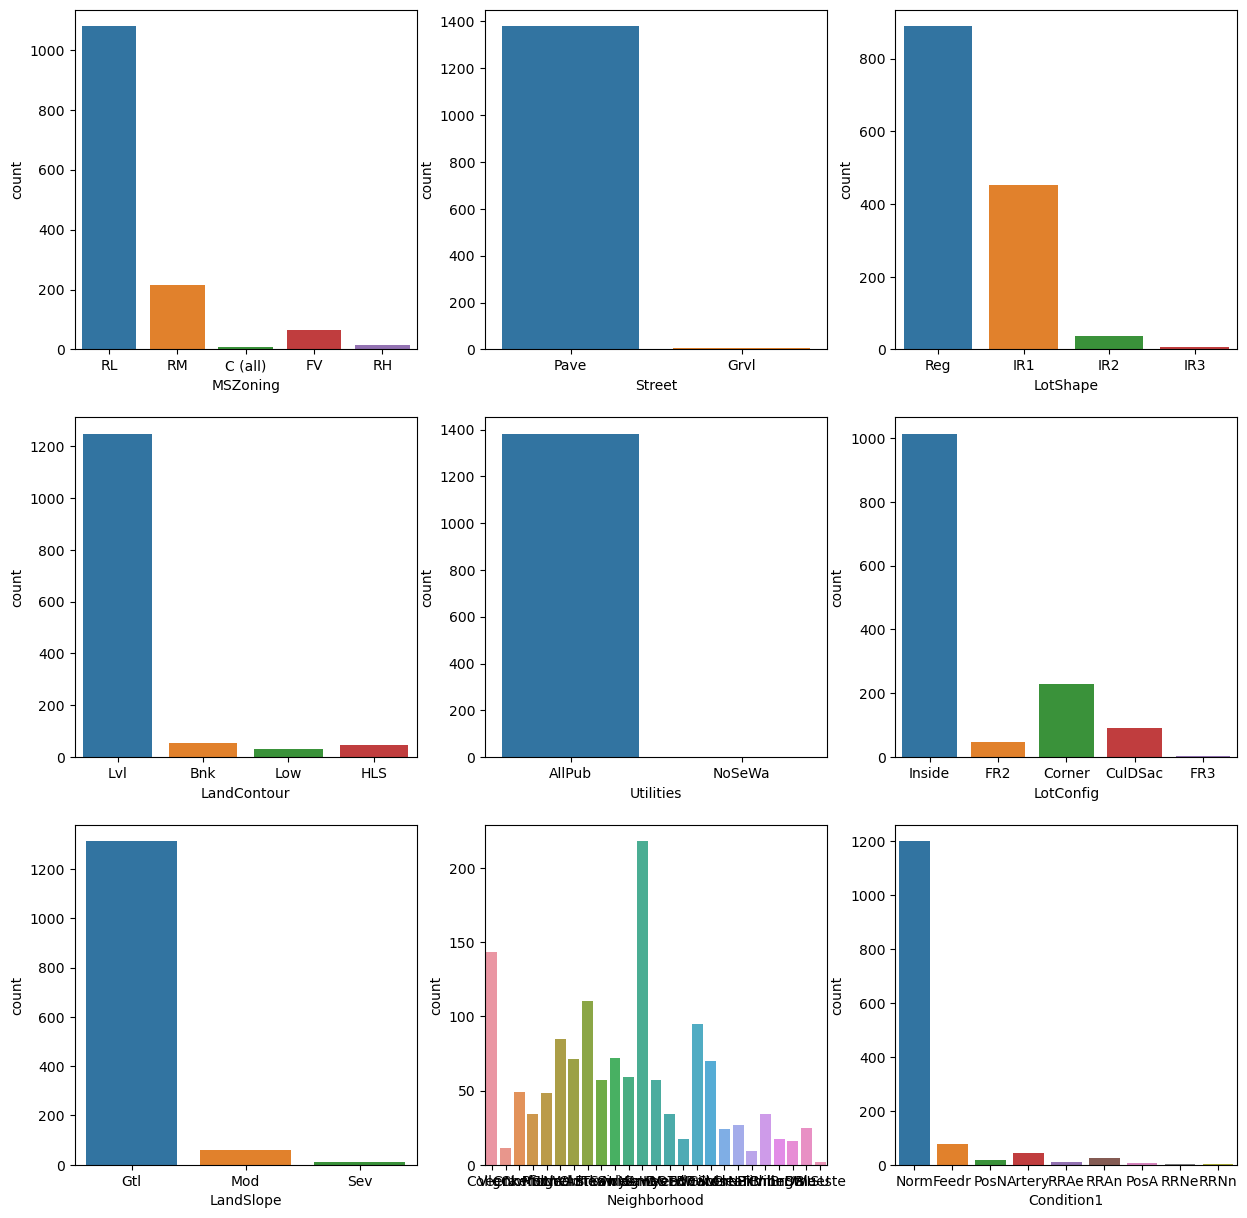

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(331)
sns.countplot(x='MSZoning', data=data)
plt.subplot(332)
sns.countplot(x='Street', data=data)
plt.subplot(333)
sns.countplot(x='LotShape', data=data)
plt.subplot(334)
sns.countplot(x='LandContour', data=data)
plt.subplot(335)
sns.countplot(x='Utilities', data=data)
plt.subplot(336)
sns.countplot(x='LotConfig', data=data)
plt.subplot(337)
sns.countplot(x='LandSlope', data=data)
plt.subplot(338)
sns.countplot(x='Neighborhood', data=data)
plt.subplot(339)
sns.countplot(x='Condition1', data=data)

In [38]:
# getting value count for "Utilities" feature
data["Utilities"].value_counts()

AllPub    1383
NoSeWa       1
Name: Utilities, dtype: int64

In [39]:
# getting value count for "Street" feature
data["Street"].value_counts()

Pave    1380
Grvl       4
Name: Street, dtype: int64

1. Looking above, features "Utilities" and "Street" have mostly one class. Hence we can remove these features.
2. Landslope feature has ordinal values.

<AxesSubplot: xlabel='ExterQual', ylabel='count'>

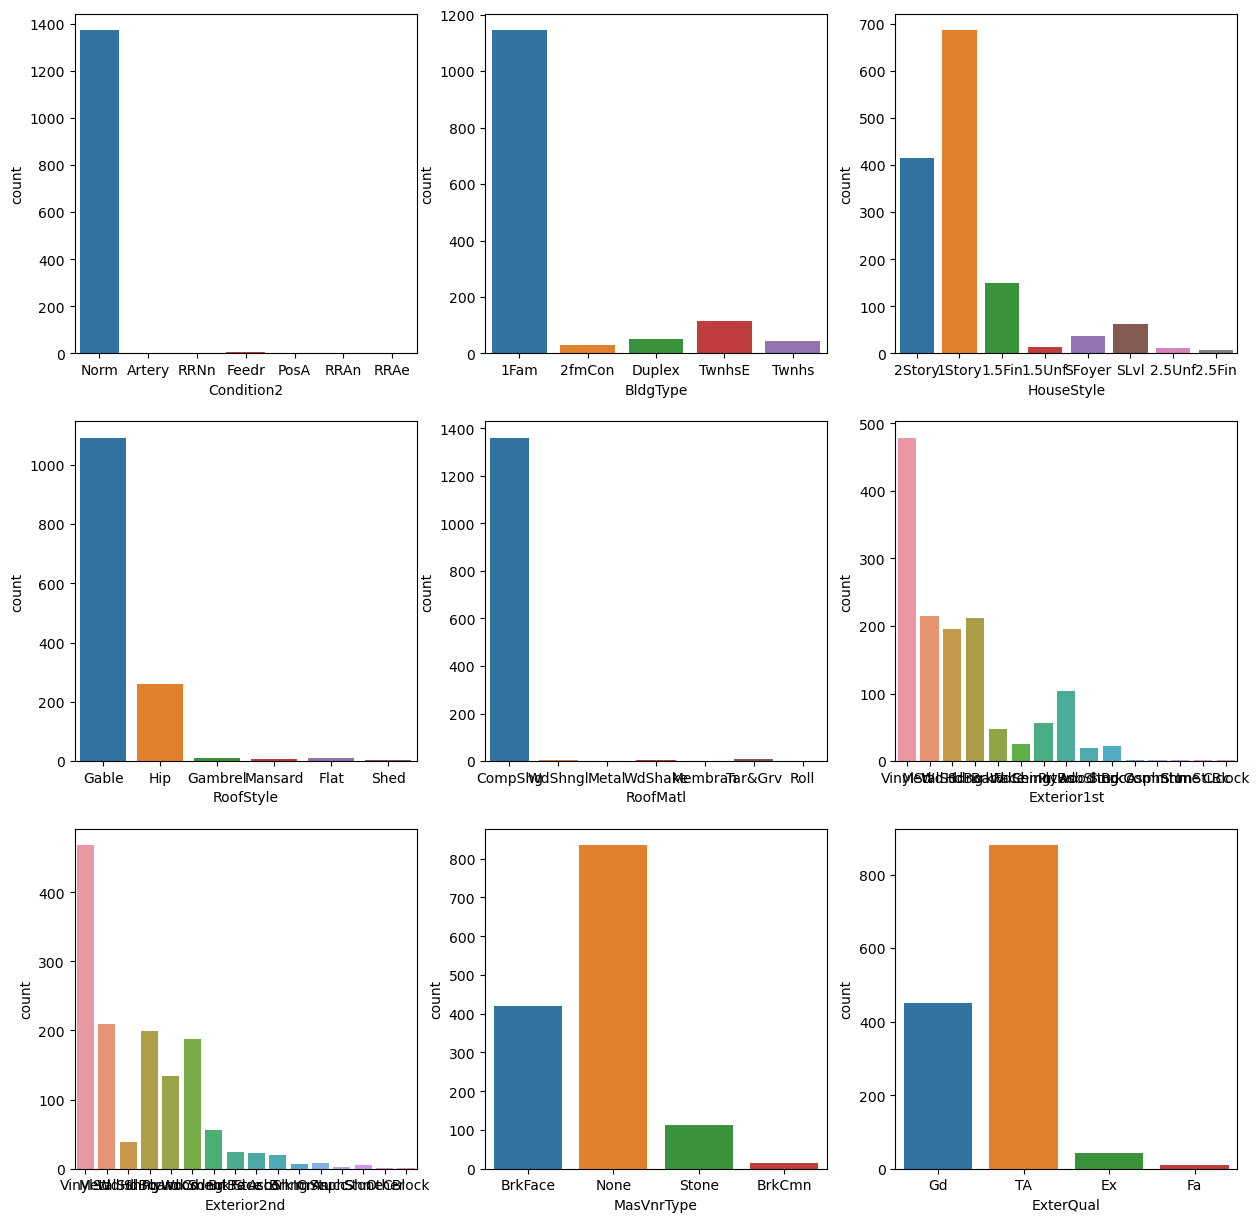

In [40]:
plt.figure(figsize=(15,15))
plt.subplot(331)
sns.countplot(x='Condition2', data=data)
plt.subplot(332)
sns.countplot(x='BldgType', data=data)
plt.subplot(333)
sns.countplot(x='HouseStyle', data=data)
plt.subplot(334)
sns.countplot(x='RoofStyle', data=data)
plt.subplot(335)
sns.countplot(x='RoofMatl', data=data)
plt.subplot(336)
sns.countplot(x='Exterior1st', data=data)
plt.subplot(337)
sns.countplot(x='Exterior2nd', data=data)
plt.subplot(338)
sns.countplot(x='MasVnrType', data=data)
plt.subplot(339)
sns.countplot(x='ExterQual', data=data)

In [41]:
# getting value count for "Condition2" feature
data["Condition2"].value_counts()

Norm      1373
Feedr        5
RRNn         2
Artery       1
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [42]:
# getting value count for "RoofMatl" feature
data["RoofMatl"].value_counts()

CompShg    1361
Tar&Grv      10
WdShngl       5
WdShake       5
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

1. Looking above, features "Condition2" and "RoofMatl" have mostly one dominant class. Hence we can remove these features.
2. ExterQual feature has ordinal values.

<AxesSubplot: xlabel='HeatingQC', ylabel='count'>

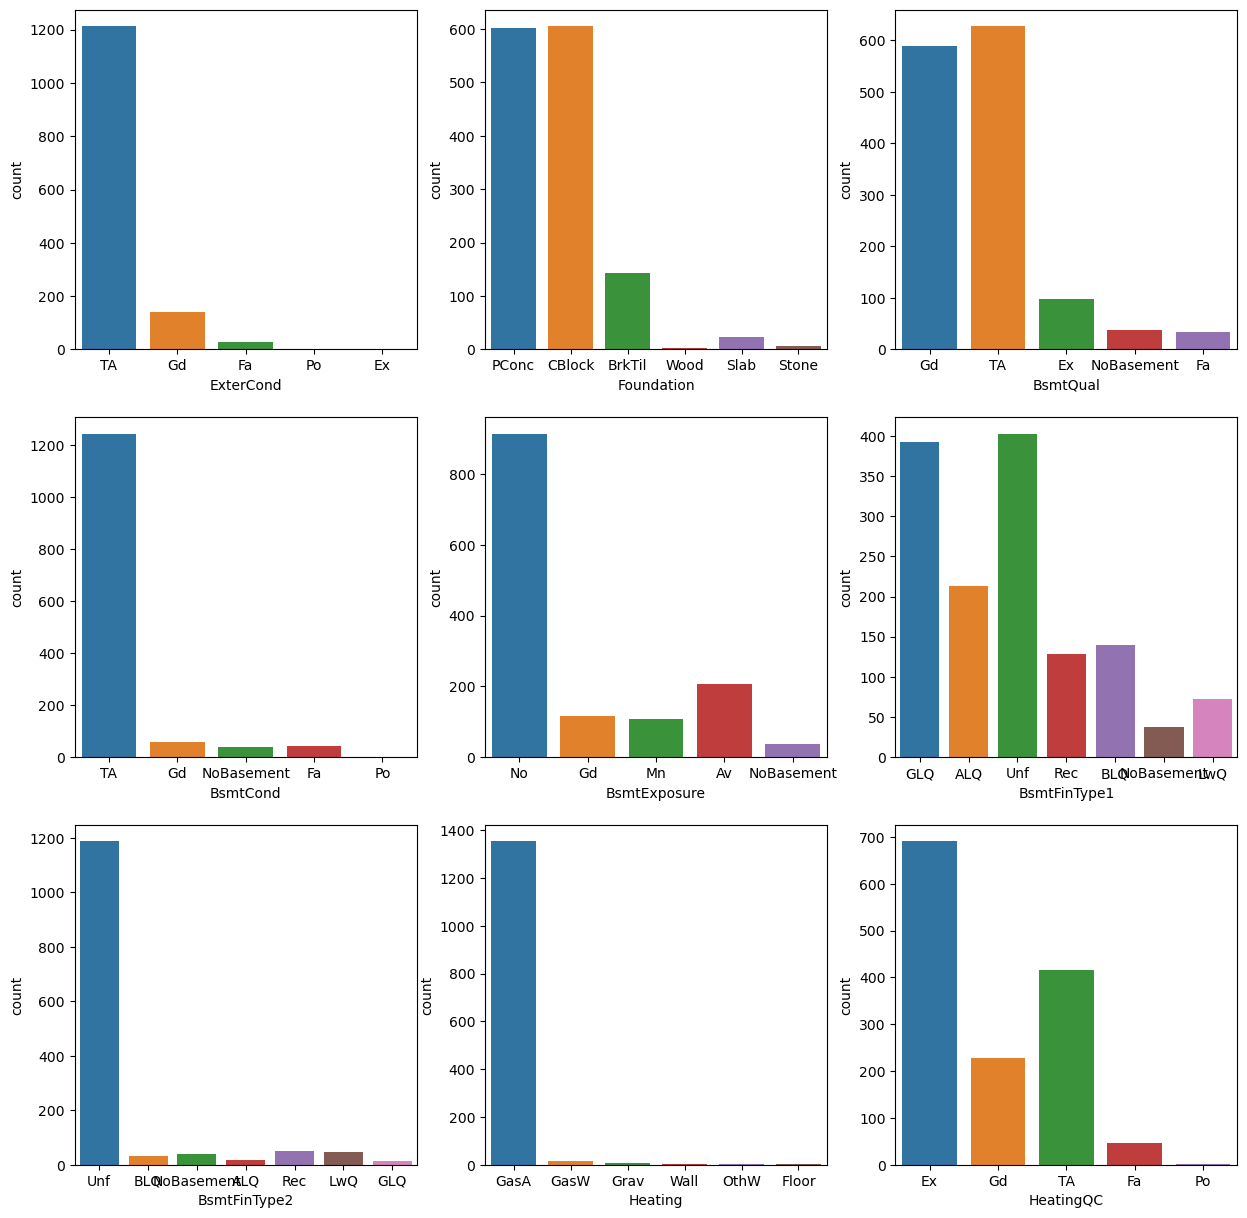

In [43]:
plt.figure(figsize=(15,15))
plt.subplot(331)
sns.countplot(x='ExterCond', data=data)
plt.subplot(332)
sns.countplot(x='Foundation', data=data)
plt.subplot(333)
sns.countplot(x='BsmtQual', data=data)
plt.subplot(334)
sns.countplot(x='BsmtCond', data=data)
plt.subplot(335)
sns.countplot(x='BsmtExposure', data=data)
plt.subplot(336)
sns.countplot(x='BsmtFinType1', data=data)
plt.subplot(337)
sns.countplot(x='BsmtFinType2', data=data)
plt.subplot(338)
sns.countplot(x='Heating', data=data)
plt.subplot(339)
sns.countplot(x='HeatingQC', data=data)

In [44]:
# getting value count for "Heating" feature
data["Heating"].value_counts()

GasA     1354
GasW       17
Grav        6
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

1. Looking above, feature "Heating" has mostly one dominant class. Hence we can remove these features.
2. "ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2" and "HeatingQC" features have ordinal values.

<AxesSubplot: xlabel='remodeled', ylabel='count'>

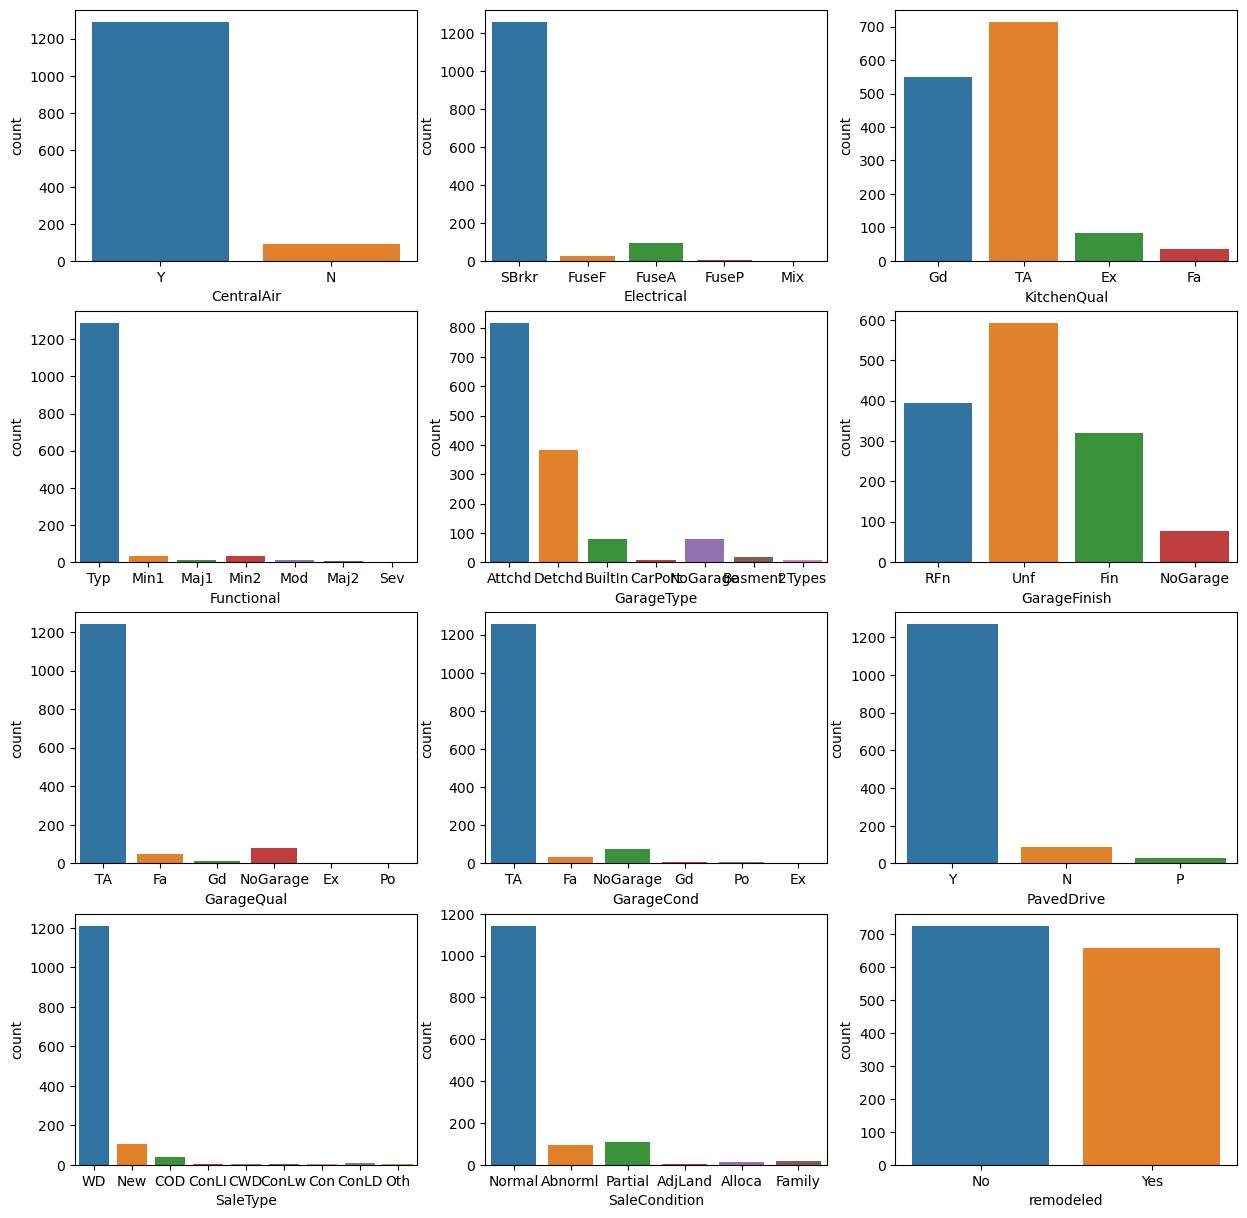

In [45]:
plt.figure(figsize=(15,15))
plt.subplot(431)
sns.countplot(x='CentralAir', data=data)
plt.subplot(432)
sns.countplot(x='Electrical', data=data)
plt.subplot(433)
sns.countplot(x='KitchenQual', data=data)
plt.subplot(434)
sns.countplot(x='Functional', data=data)
plt.subplot(435)
sns.countplot(x='GarageType', data=data)
plt.subplot(436)
sns.countplot(x='GarageFinish', data=data)
plt.subplot(437)
sns.countplot(x='GarageQual', data=data)
plt.subplot(438)
sns.countplot(x='GarageCond', data=data)
plt.subplot(439)
sns.countplot(x='PavedDrive', data=data)
plt.subplot(4,3,10)
sns.countplot(x='SaleType', data=data)
plt.subplot(4,3,11)
sns.countplot(x='SaleCondition', data=data)
plt.subplot(4,3,12)
sns.countplot(x='remodeled', data=data)

In [46]:
# getting value count for "Functional" feature
data["Functional"].value_counts()

Typ     1288
Min2      33
Min1      31
Mod       14
Maj1      13
Maj2       4
Sev        1
Name: Functional, dtype: int64

"KitchenQual","GarageFinish","GarageQual","GarageCond" features have ordinal values

## Data preparation

-  encoding of variables (dummy variables and ordinal variables)
-  train - test split
-  feature scaling


### Encoding

In [47]:
# encoding ordinal variables

# "ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","GarageFinish",
#"GarageQual","GarageCond","LandSlope","ExterQual"

data['KitchenQual'] = data.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['GarageFinish'] = data.GarageFinish.map({'NoGarage':0,'Unf':1,'RFn':2,'Fin':3})
data['GarageQual'] = data.GarageQual.map({'NoGarage':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['GarageCond'] = data.GarageCond.map({'NoGarage':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['ExterCond'] = data.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['BsmtQual'] = data.BsmtQual.map({'NoBasement':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['BsmtCond'] = data.BsmtCond.map({'NoBasement':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['BsmtExposure'] = data.BsmtExposure.map({'NoBasement':0,'No':1,'Mn':2,'Av':3,'Gd':4})
data['BsmtFinType1'] = data.BsmtFinType1.map({'NoBasement':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
data['BsmtFinType2'] = data.BsmtFinType2.map({'NoBasement':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
data['HeatingQC'] = data.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['LandSlope'] = data.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
data['ExterQual'] = data.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

In [48]:
data.shape

(1384, 73)

In [49]:
# creating dummy variables for rest of the categorical values
dummy_cols = pd.get_dummies(data[['MSZoning', 'LotShape', 'LandContour','LotConfig', 'Neighborhood', 'Condition1','BldgType', 'HouseStyle', 'RoofStyle', 
                                  'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                                  'BsmtFinType2', 'CentralAir', 'Electrical','Functional', 'GarageType', 'GarageFinish','PavedDrive', 'SaleType', 
                                  'SaleCondition', 'remodeled']],drop_first = True)

In [50]:
data = pd.concat([data,dummy_cols],axis='columns')

In [51]:
data.shape

(1384, 211)

dropping all original variables from which dummy variables got greated and 
"Utilities","Street","Condition2","RoofMatl","Heating" variables

In [52]:
data = data.drop(['MSZoning', 'LotShape', 'LandContour','LotConfig', 'Neighborhood', 'Condition1','BldgType', 'HouseStyle', 'RoofStyle',
                  'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
                  'CentralAir', 'Electrical','Functional', 'GarageType', 'GarageFinish','PavedDrive', 'SaleType','SaleCondition', 'remodeled'],axis='columns')
data = data.drop(["Utilities","Street","Condition2","RoofMatl","Heating"],axis=1)

In [53]:
data.shape

(1384, 173)

### Splitting data into Training and Test Sets

In [54]:
from sklearn.model_selection import train_test_split

# We specify random so that the train and test data set always have the same rows, respectively after splitting.
np.random.seed(0)
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the features

In [55]:
data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'LandSlope', 'OverallQual',
       'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'remodeled_Yes'],
      dtype='object', length=173)

Performing standard scaling on numeric columns

In [56]:
df_train.SalePrice

570     142600
1034    119750
520     106250
534     178000
1072     91500
         ...  
845     171000
58      438780
376     148000
84      168500
835     128000
Name: SalePrice, Length: 968, dtype: int64

In [57]:
numericCols = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
               'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
               'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces','GarageYrBlt','GarageArea', 'WoodDeckSF', 'OpenPorchSF',
               'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold','YrSold', 'SalePrice','Yr_diff']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Apply scaler() to numeric features
df_train[numericCols] = scaler.fit_transform(df_train[numericCols])
df_test[numericCols] = scaler.transform(df_test[numericCols])

In [58]:
df_train.head()

,MSSubClass,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,remodeled_Yes
570,0.711174,0.442277,0.312747,0,-0.765755,-0.515253,-0.904584,0.048649,2,2,...,0,0,0,1,0,0,0,1,0,0
1034,-0.658582,-1.027256,-0.415729,0,-0.765755,1.311725,-1.624483,-0.567679,2,3,...,0,0,0,1,0,0,0,1,0,1
520,2.994100,-0.414951,0.066098,0,-1.505527,1.311725,0.775181,-0.567679,2,2,...,0,0,0,1,0,0,0,1,0,1
534,0.026296,0.442277,-0.120844,0,1.453559,-0.515253,0.967154,-0.567679,3,2,...,0,0,0,1,0,0,0,1,0,0
1072,-0.201997,-1.027256,-0.278523,0,-0.765755,-2.342231,-1.624483,-0.567679,2,2,...,0,0,0,1,0,0,0,1,0,1


### Dividing into X and Y sets for the model building

In [59]:
# taking only SalePrice column in y_train and rest of the dataframe as X_train
y_train = df_train.pop('SalePrice')
X_train = df_train

# taking only SalePrice column in y_test and rest of the dataframe as X_test
y_test = df_test.pop('SalePrice')
X_test = df_test

In [60]:
X_train[X_train.columns[X_train.isnull().any()]].isnull().sum() * 100 / X_train.shape[0]

Series([], dtype: float64)

## Training model

### Model 1: Training Linear regression using RFE

In [61]:
from sklearn import linear_model, metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the number of features to select equal to 30
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select = 30)
rfe = rfe.fit(X_train, y_train)

In [63]:
col = X_train.columns[rfe.support_]
col

Index(['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'KitchenQual', 'Yr_diff',
       'LotShape_IR2', 'Neighborhood_CollgCr', 'Neighborhood_Gilbert',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Condition1_RRAe',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'Exterior1st_AsphShn',
       'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Stucco',
       'Exterior2nd_AsphShn', 'Exterior2nd_CmentBd', 'Functional_Typ',
       'SaleType_Con', 'SaleType_New', 'SaleCondition_AdjLand',
       'SaleCondition_Normal'],
      dtype='object')

In [64]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred_train = rfe.predict(X_train)
y_pred_test = rfe.predict(X_test)

In [65]:
metric1 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r square training score: " + r2_train_lr,2)))
metric1.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r square test score: " + str(round(r2_test_lr,2)))
metric1.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss training score: " + str(round(rss1_lr,2)))
metric1.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss test score: " + str(round(rss2_lr,2)))
metric1.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse training score: " + str(round(mse_train_lr,2)))
metric1.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse test score: " + str(round(mse_test_lr,2)))
metric1.append(mse_test_lr**0.5)

r square training score: 0.87
r square test score: 0.8300000000000001
rss training score: 130.63
rss test score: 62.940000000000005
mse training score: 0.13
mse test score: 0.15


For linear regression with RFE, the r square training score comes out to be 0.87 and r square test score to be 0.83

### Model 2: Linear Regression with Ridge Regularization

In [66]:
#list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [67]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)
print(model_cv.best_score_)

{'alpha': 20}
-0.22292351361691365


In [68]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 20
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-6.66378464e-02  2.60002498e-02  4.95067760e-02 -3.08630279e-02
  1.95834886e-01  7.70522491e-02  1.07313069e-02  6.54021541e-02
  1.07184857e-01 -6.01360335e-02  1.05696662e-01  1.01129928e-02
 -2.47313264e-02  8.69380521e-02  1.58340817e-02  1.32815694e-01
  1.01392699e-01  7.94479437e-03  1.91784711e-01  1.66682552e-02
 -1.13865669e-02  2.44215201e-02  2.91233963e-02 -4.09860342e-02
 -3.77403991e-02  9.11924511e-02  3.65904891e-02 -4.53420209e-02
  8.05229660e-02  7.81801818e-02 -5.44673415e-02  3.41722159e-02
  2.88843201e-02 -1.78830947e-04  1.19794947e-02  3.37745400e-03
  1.35817950e-02 -2.15330988e-02  6.22867409e-04 -1.23868556e-01
  9.74332799e-03 -1.95220761e-03  5.66696516e-02  9.13082192e-03
  6.96021050e-02  5.96930744e-04 -4.14825343e-02  7.54762658e-02
 -3.09767788e-02 -7.00581788e-03  8.43938403e-02 -1.06064334e-02
 -2.20646678e-03  1.30937402e-02  6.17798569e-03  3.22600914e-02
  4.56137113e-02  2.99991396e-02 -5.81554988e-02  1.41529890e-01
 -3.28630331e-02 -7.77744

In [87]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r square training score: " + str(round(r2_train_lr,2)))
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r square test score: " + str(round(r2_test_lr,2)))
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss training score: " + str(round(rss1_lr,2)))
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss test score: " + str(round(rss2_lr,2)))
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse training score: " + str(round(mse_train_lr,2)))
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse test score: " + str(round(mse_test_lr,2)))
metric2.append(mse_test_lr**0.5)

r square training score: 0.91
r square test score: 0.9
rss training score: 82.69
rss test score: 34.95
rmse training score: 0.09
rmse test score: 0.08


We can see that the r square training score is 0.91 and r square test score is 0.9 which has improved from linear regression with RFE.

### Model 3: Linear Regression with Lasso Regularization

In [70]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [71]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.001}


In [90]:
alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [91]:
lasso.coef_

array([-4.41372093e-02,  1.60514582e-02,  4.62769861e-02, -1.37618478e-02,
        1.87218742e-01,  7.82750066e-02,  5.84833086e-03,  5.85606606e-02,
        9.76556358e-02, -6.71541725e-02,  1.27459946e-01,  1.91979434e-02,
       -0.00000000e+00,  5.68705610e-02,  1.18322653e-02,  4.80442157e-02,
        0.00000000e+00, -1.47861775e-03,  3.12399019e-01,  1.46134311e-02,
       -8.07961199e-03,  1.88621287e-02,  2.49267324e-02, -3.71282007e-02,
       -4.17797708e-02,  9.08870458e-02,  3.33189915e-02, -5.72473912e-02,
        7.55639552e-02,  1.00288280e-01, -6.90825531e-02,  3.65069280e-02,
        2.99403814e-02,  0.00000000e+00,  1.08222043e-02,  4.88947948e-03,
        1.27684197e-02, -2.40598907e-02,  1.30062379e-03, -1.49499974e-01,
        0.00000000e+00, -0.00000000e+00,  1.84578091e-02,  0.00000000e+00,
        7.61340445e-02,  0.00000000e+00, -2.76298293e-02,  4.87816474e-02,
       -3.27430887e-03,  0.00000000e+00,  9.54127759e-02, -0.00000000e+00,
       -0.00000000e+00,  

In [74]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r square training score: " + str(round(r2_train_lr,2)))
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r square test score: " + str(round(r2_test_lr,2)))
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss training score: " + str(round(rss1_lr,2)))
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss test score: " + str(round(rss2_lr,2)))
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse training score: " + str(round(mse_train_lr,2)))
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse test score: " + str(round(mse_test_lr,2)))
metric3.append(mse_test_lr**0.5)

r square training score: 0.92
r square test score: 0.91
rss training score: 79.48
rss test score: 34.5
mse training score: 0.08
mse test score: 0.08


In [88]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': metric1
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.865052,0.914574,0.917888
1,R2 Score (Test),0.827203,0.904061,0.905282
2,RSS (Train),130.629210,82.692226,79.483941
3,RSS (Test),62.943383,34.946968,34.502165
4,RMSE (Train),0.367352,0.292277,0.286551
5,RMSE (Test),0.388981,0.289840,0.287989


We can see that the r square training score is 0.92 and r square test score is 0.91 which has improved from ridge regression and linear regression with RFE.
Hence, Linear regression with Lasso Regularization generates best model.

## Assignment Questions

### Question 1

Making value of alpha in ridge regression equals 40 (double of 20) and for lasso regression, making alpha equal 0.002 (double of 0.001)

In [77]:
#Fitting Ridge model for alpha = 10
alpha = 40
ridge_double = Ridge(alpha=alpha)

ridge_double.fit(X_train, y_train)

Ridge(alpha=40)

In [78]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge_double.predict(X_train)
y_pred_test = ridge_double.predict(X_test)

metric4 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r square training score: " + str(round(r2_train_lr,2)))
metric4.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r square test score: " + str(round(r2_test_lr,2)))
metric4.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss training score: " + str(round(rss1_lr,2)))
metric4.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss test score: " + str(round(rss2_lr,2)))
metric4.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse training score: " + str(round(mse_train_lr,2)))
metric4.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse test score: " + str(round(mse_test_lr,2)))
metric4.append(mse_test_lr**0.5)

r square training score: 0.91
r square test score: 0.9
rss training score: 87.32000000000001
rss test score: 35.53
mse training score: 0.09
mse test score: 0.09


In [81]:
# Important predictors variables after the change is implemented alpha=40 for ridge
ridge_df = pd.DataFrame() 
ridge_df['Coeff Values'] = pd.Series(ridge_double.coef_) 
ridge_df['Variables'] = X_train.columns

ridge_df = ridge_df.loc[ridge_df['Coeff Values']!=0]

ridge_df['Absolute Coefficent'] =ridge_df['Coeff Values'].apply(lambda x:abs(x))
ridge_df.sort_values(by=['Absolute Coefficent'],inplace=True,ascending=False)

ridge_df.head(10)

,Coeff Values,Variables,Absolute Coefficent
4,0.197513,OverallQual,0.197513
18,0.185436,GrLivArea,0.185436
15,0.131211,1stFlrSF,0.131211
75,0.127301,Neighborhood_StoneBr,0.127301
163,0.120601,SaleType_New,0.120601
8,0.112025,ExterQual,0.112025
149,0.107211,Functional_Typ,0.107211
39,-0.106479,Yr_diff,0.106479
10,0.106154,BsmtFinSF1,0.106154
59,0.103766,Neighborhood_Crawfor,0.103766


In [84]:
#Fitting lasso model for alpha = 0.002
alpha =0.002

lasso_double = Lasso(alpha=alpha)
        
lasso_double.fit(X_train, y_train) 

Lasso(alpha=0.002)

In [85]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso_double.predict(X_train)
y_pred_test = lasso_double.predict(X_test)

metric5 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r square training score: " + str(round(r2_train_lr,2)))
metric5.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r square test score: " + str(round(r2_test_lr,2)))
metric5.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("rss training score: " + str(round(rss1_lr,2)))
metric5.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("rss test score: " + str(round(rss2_lr,2)))
metric5.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("mse training score: " + str(round(mse_train_lr,2)))
metric5.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("mse test score: " + str(round(mse_test_lr,2)))
metric5.append(mse_test_lr**0.5)

r square training score: 0.91
r square test score: 0.91
rss training score: 84.51
rss test score: 34.31
mse training score: 0.09
mse test score: 0.08


In [86]:
# Important predictors variables after the change is implemented alpha=0.002 for lasso
lasso_df = pd.DataFrame() 
lasso_df['Coeff Values'] = pd.Series(lasso_double.coef_) 
lasso_df['Variables'] = X_train.columns

lasso_df = lasso_df.loc[lasso_df['Coeff Values']!=0]

lasso_df['Absolute Coefficent'] =lasso_df['Coeff Values'].apply(lambda x:abs(x))
lasso_df.sort_values(by=['Absolute Coefficent'],inplace=True,ascending=False)

lasso_df.head(10)

,Coeff Values,Variables,Absolute Coefficent
75,0.418175,Neighborhood_StoneBr,0.418175
163,0.337145,SaleType_New,0.337145
18,0.322534,GrLivArea,0.322534
59,0.212594,Neighborhood_Crawfor,0.212594
4,0.195404,OverallQual,0.195404
120,0.194610,Exterior2nd_CmentBd,0.194610
149,0.174201,Functional_Typ,0.174201
69,0.150636,Neighborhood_NridgHt,0.150636
68,0.146207,Neighborhood_NoRidge,0.146207
39,-0.134924,Yr_diff,0.134924


### Question 3

Top five columns in lasso regression.

In [92]:
# Important predictors variables after the change is implemented alpha=0.001 for lasso
lasso_df = pd.DataFrame() 
lasso_df['Coeff Values'] = pd.Series(lasso.coef_) 
lasso_df['Variables'] = X_train.columns

lasso_df = lasso_df.loc[lasso_df['Coeff Values']!=0]

lasso_df['Absolute Coefficent'] =lasso_df['Coeff Values'].apply(lambda x:abs(x))
lasso_df.sort_values(by=['Absolute Coefficent'],inplace=True,ascending=False)

lasso_df.head(10)

,Coeff Values,Variables,Absolute Coefficent
75,0.516205,Neighborhood_StoneBr,0.516205
163,0.340802,SaleType_New,0.340802
18,0.312399,GrLivArea,0.312399
59,0.255295,Neighborhood_Crawfor,0.255295
120,0.218997,Exterior2nd_CmentBd,0.218997
88,-0.216428,BldgType_Twnhs,0.216428
69,0.199903,Neighborhood_NridgHt,0.199903
68,0.194410,Neighborhood_NoRidge,0.194410
82,-0.193198,Condition1_RRAe,0.193198
149,0.191407,Functional_Typ,0.191407


Top five predictor variables are: Neighborhood_StoneBr, SaleType_New, GrLivArea , Neighborhood_Crawfor and Exterior2nd_CmentBd

In [94]:
# getting new dataframe excluding top 5 lasso features
X_train_new = X_train.loc[:,~X_train.columns.isin(["Neighborhood_StoneBr", "SaleType_New", "GrLivArea" , "Neighborhood_Crawfor","Exterior2nd_CmentBd"])]
X_test_new = X_test.loc[:,~X_test.columns.isin(["Neighborhood_StoneBr", "SaleType_New", "GrLivArea" , "Neighborhood_Crawfor","Exterior2nd_CmentBd"])]

In [97]:
X_test_new.shape

(416, 167)

In [98]:
#Fitting lasso model for alpha = 0.002
alpha =0.001

lasso_q3 = Lasso(alpha=alpha)
        
lasso_q3.fit(X_train_new, y_train)

Lasso(alpha=0.001)

In [100]:
# Important predictors variables after the change is implemented alpha=0.001 for lasso
lasso_df = pd.DataFrame() 
lasso_df['Coeff Values'] = pd.Series(lasso_q3.coef_) 
lasso_df['Variables'] = X_train_new.columns

lasso_df = lasso_df.loc[lasso_df['Coeff Values']!=0]

lasso_df['Absolute Coefficent'] =lasso_df['Coeff Values'].apply(lambda x:abs(x))
lasso_df.sort_values(by=['Absolute Coefficent'],inplace=True,ascending=False)

lasso_df.head(10)

,Coeff Values,Variables,Absolute Coefficent
165,0.297066,SaleCondition_Partial,0.297066
15,0.293535,1stFlrSF,0.293535
16,0.282948,2ndFlrSF,0.282948
103,0.219799,Exterior1st_CemntBd,0.219799
85,-0.218242,BldgType_Twnhs,0.218242
65,-0.205898,Neighborhood_NWAmes,0.205898
4,0.204707,OverallQual,0.204707
79,-0.189542,Condition1_RRAe,0.189542
145,0.180606,Functional_Typ,0.180606
101,0.177409,Exterior1st_BrkFace,0.177409


New top five predictor variables are :  "SaleCondition_Partial","1stFlrSF" ,"2ndFlrSF","Exterior1st_CemntBd","BldgType_Twnhs"